### Exploring the moment tensor database. 

#### The eventual aim is the run a clustering algorithm on the earthquake information to see if it can reveal geological patterns

Also contains some experimental plotting with basemap

In [1]:
import pandas as pd
import obspy as op
import numpy as np
from MT_helper import read_quakes
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
quakes = read_quakes('jan76_dec17.ndk')

In [3]:
quakes.head()

,Dep,Dip_1,Dip_2,Lat,Lon,MPP,MRP,MRR,MRT,MTP,MTT,Mag,Rake_1,Rake_2,Strike_1,Strike_2
0,59.0,93,88,-28.61,182.36,-7.770,4.520,7.680,1.390,-3.260,0.090,6.2,30,60,202,18
1,95.0,-60,-105,-13.29,285.10,2.370,1.970,-1.780,-1.280,-2.900,-0.590,6.0,28,66,350,137
2,33.0,78,94,51.60,159.33,-0.800,1.240,1.100,1.050,-0.560,-0.300,5.7,18,73,206,39
3,168.0,-86,-91,-15.76,167.87,-0.590,-1.230,-1.700,-2.330,2.010,2.290,6.1,22,68,246,62
4,33.0,173,9,66.16,343.42,3.370,-0.780,-0.510,0.050,-0.860,-2.860,6.0,82,83,127,218


In [4]:
quakes.dropna(inplace=True)
cols = quakes.columns
quakes[cols] = quakes[cols].apply(pd.to_numeric, errors='coerce')

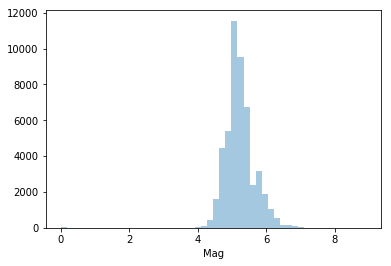

In [5]:
sns.distplot(quakes['Mag'],kde=False)

Now that we have the dataframe, the next step is to plot the events and then see if we can do some sort of cluster analysis to understand their distribution 

In [6]:
from mpl_toolkits.basemap import Basemap
from obspy.imaging.beachball import beach

In [7]:
def select_color(dep):
    
    '''Function used to color the focal mechanisms by depth'''
    
    if dep <= 10:
        return 'red'
    elif 10 < dep <= 30:
        return 'blue'
    elif 30 < dep <= 50:
        return 'green'
    elif 50 < dep <= 100:
        return 'yellow'
    elif 100 < dep <= 150:
        return 'orange'
    elif 150 < dep <= 250:
        return 'cyan'
    else:
        return 'black'

#### Plot a sample of the MT database

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/obspy/imaging/beachball.py:191: UserWarning: There is a known bug when plotting semi-transparent patches for non-DC sources, which leads to blending of pressure and tension color, see issue #1464.
  warnings.warn(msg)


Text(0.5,1,'Selected earthquakes')

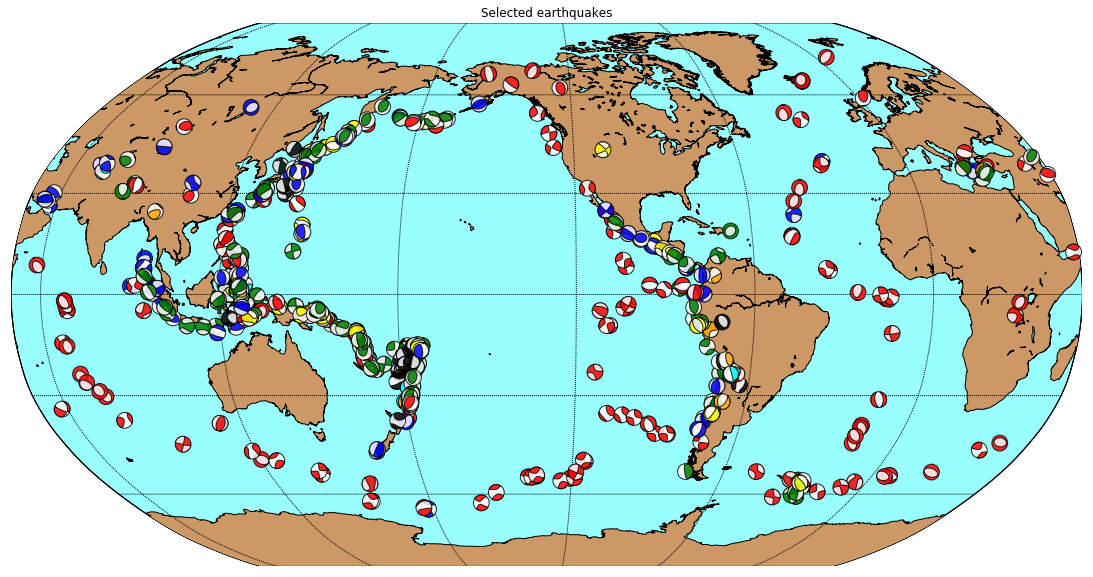

In [8]:
#Set up the map
plt.figure(figsize=(20,10))
m = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0,
              lat_0=0, lon_0=-130)
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(np.arange(-90., 120., 30.))
m.drawmeridians(np.arange(0., 420., 60.))
m.drawmapboundary()
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')

ax = plt.gca()
focal_planes = quakes[['Lat','Lon','Dep','Strike_1','Dip_1','Rake_1','MRR','MTT','MPP','MRT','MRP','MTP']].sample(500)

for index, row in focal_planes.iterrows():
    mt = [row['MRR'],row['MTT'],row['MPP'],row['MRT'],row['MRP'],row['MTP']]
    ll = (row['Lon'],row['Lat'])
    x,y = m(ll[0],ll[1])
    col = select_color(row['Dep'])
    
    b = beach(mt, xy=(x,y), width=500000, linewidth=1, alpha=0.85, facecolor=col)
    b.set_zorder(10)
    ax.add_collection(b)

plt.title("Selected earthquakes")
    

### What do we want to do with regard to clustering? 

We want to see if an unsupervised clustering algororithm can detect geographically reasonable patterns in this earthquake database. We'll use information 
about the two nodal planes, the lon, lat, depth and magnitude of the events. Hopefully we'll be able to group the events by some reasonable metric

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [39]:
X = quakes[['Dep','Strike_1','Dip_1','Rake_2','Strike_2','Dip_2','Rake_2']]
#Note that we could also inlcude lon and lat in the clustering, but here we don't care about location

In [40]:
sc = StandardScaler()

In [41]:
sc.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [42]:
X_scaled = sc.transform(X)

In [43]:
len(X_scaled)

49524

In [44]:
classifier = KMeans(n_clusters=10)

In [45]:
classifier.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
quakes_labelled = quakes.copy()

In [47]:
quakes_labelled['label'] = classifier.labels_
unique_labs = pd.unique(quakes_labelled['label'])
print(unique_labs)

[5 7 4 1 6 8 2 3 0 9]


(0, 400)

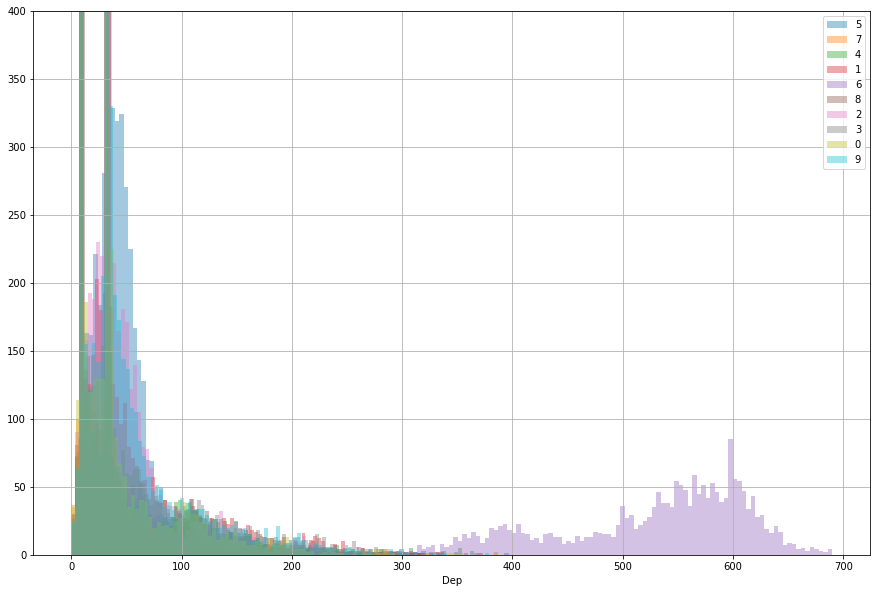

In [48]:
plt.figure(figsize=(15,10))
for element in unique_labs:
    label = str(element)
    sns.distplot(quakes_labelled[quakes_labelled['label']==element]['Dep'],bins=100,kde=False,label=label)
plt.legend()
plt.grid()
plt.ylim([0,400])

Its not clear how well this has worked

#### Plotting the events on a map by cluster

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/obspy/imaging/beachball.py:191: UserWarning: There is a known bug when plotting semi-transparent patches for non-DC sources, which leads to blending of pressure and tension color, see issue #1464.
  warnings.warn(msg)
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/obspy/imaging/beachball.py:54: UserWarning: Encountered an exception while plotting the beachball. Falling back to the mopad wrapper which is slower but more stable.
  warnings.warn(msg)


Text(0.5,1,'Selected earthquakes - MT ')

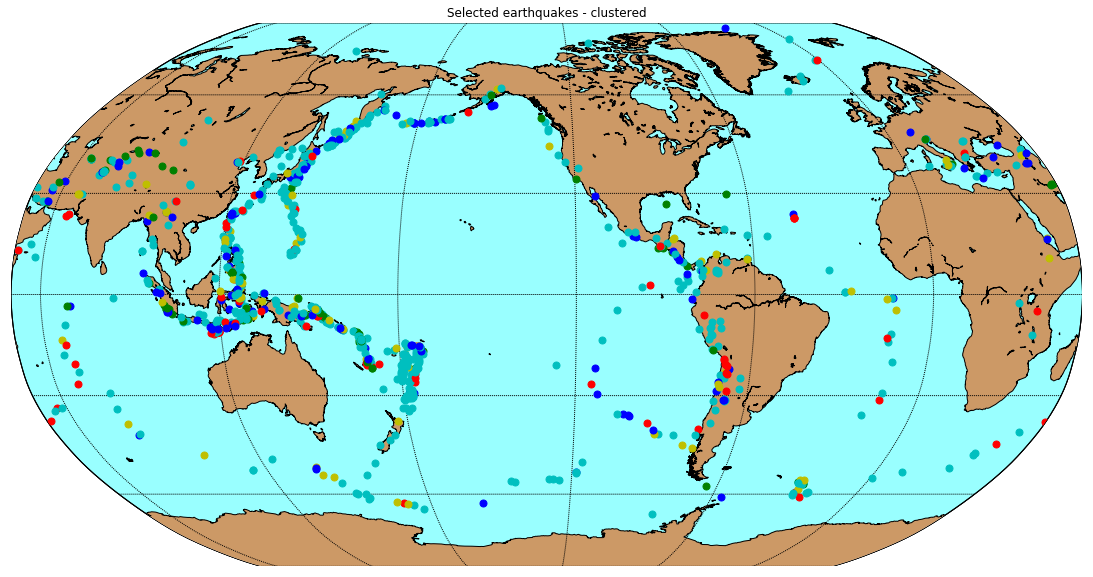

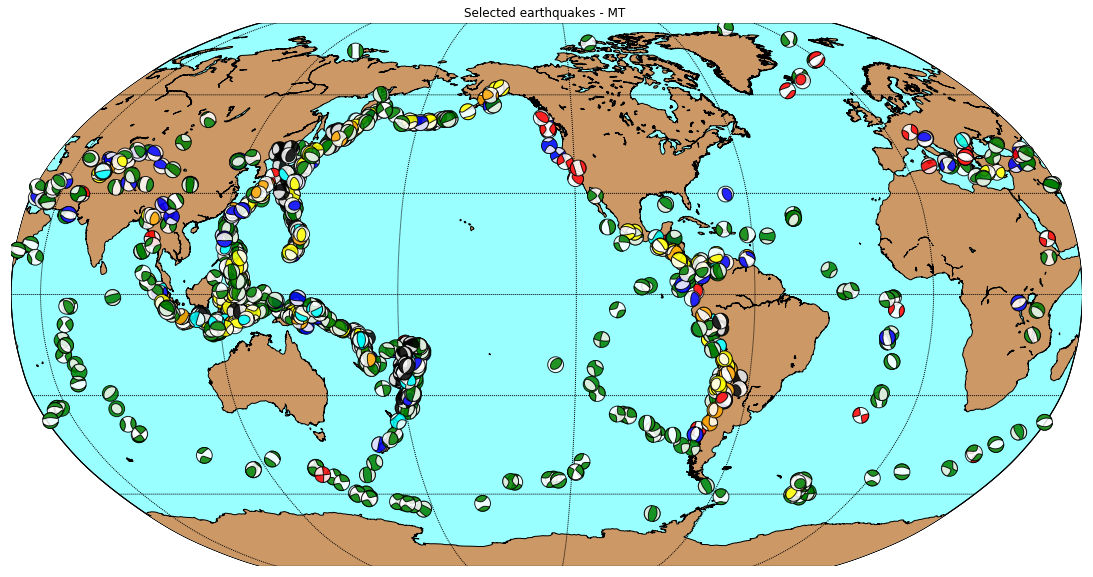

In [49]:
#Set up the map
plt.figure(figsize=(20,10))
m = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0,
              lat_0=0, lon_0=-130)
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(np.arange(-90., 120., 30.))
m.drawmeridians(np.arange(0., 420., 60.))
m.drawmapboundary()
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')

ax = plt.gca()
qplot = quakes_labelled[['Lat','Lon','Dep','label']].loc[:1000]

for index, row in qplot.iterrows():
    ll = (row['Lon'],row['Lat'])
    x,y = m(ll[0],ll[1])
    
    label = row['label']
    if label == 0:
        mc = 'ro'
    elif label == 1:
        mc = 'bo'
    elif label == 2:
        mc = 'go'
    elif label == 3:
        mc = 'yo'
    else:
        mc = 'co'
        
    m.plot(x, y, mc, markersize=7)

plt.title("Selected earthquakes - clustered")

###############################
# MT map
###############################

plt.figure(figsize=(20,10))
m = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0,
              lat_0=0, lon_0=-130)
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(np.arange(-90., 120., 30.))
m.drawmeridians(np.arange(0., 420., 60.))
m.drawmapboundary()
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')

ax = plt.gca()
focal_planes = quakes[['Lat','Lon','Dep','Strike_1','Dip_1','Rake_1','MRR','MTT','MPP','MRT','MRP','MTP']].loc[:1000]

for index, row in focal_planes.iterrows():
    mt = [row['MRR'],row['MTT'],row['MPP'],row['MRT'],row['MRP'],row['MTP']]
    ll = (row['Lon'],row['Lat'])
    x,y = m(ll[0],ll[1])
    col = select_color(row['Dep'])
    
    b = beach(mt, xy=(x,y), width=500000, linewidth=1, alpha=0.85, facecolor=col)
    b.set_zorder(10)
    ax.add_collection(b)

plt.title("Selected earthquakes - MT ")

This is interesting, but probably not very useful. There is some correlation between quake types and the clusters, but we'd need to a much more extensive analysis to see how good it is.

This problem is probably more suited to a supervised learning algorithm, which could be trained on labels describing the type of event. New events could then be classified as such. This leads the way towards earthquake vs explosion discrimination using machine learning.  